In [2]:
import h5py
import numpy as np
import torch
from torchvision import transforms

import h5py
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt



DINO_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def crop_top_middle(image):
    top = 30
    left = 28
    height = 192
    width = 192
    return F.crop(image, top, left, height, width)

crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: crop_top_middle(img)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
DINO_crop = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.1)),
    transforms.Lambda(lambda img: crop_top_middle(img)),
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



/home/intent/miniconda3/envs/sunny/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/intent/miniconda3/envs/sunny/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
from sklearn.decomposition import PCA

def get_dino_features(dinov2, images):
    patch_h = 16
    patch_w = 16
    feat_dim = 384 # vits14
    N = 1
    """
    Extract DINOv2 features from a batch of images.
    
    Args:
        dinov2: The DINOv2 model.
        images: A batch of images as a tensor.
        
    Returns:
        A tensor of extracted features.
    """
    with torch.no_grad():
        features_dict = dinov2.forward_features(images)
        features = features_dict['x_norm_patchtokens']

    features = features.reshape(patch_h * patch_w, feat_dim)

    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)

    
    pca_features_bg = pca_features[:, 0] < -np.inf
    pca_features_fg = ~pca_features_bg

    # PCA for only foreground patches
    pca.fit(features[pca_features_fg]) # NOTE: I forgot to add it in my original answer
    pca_features_rem = pca.transform(features[pca_features_fg])
    for i in range(3):
        pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())

    pca_features_rgb = pca_features.copy()
    pca_features_rgb[pca_features_bg] = 0
    pca_features_rgb[pca_features_fg] = pca_features_rem

    pca_features_rgb = pca_features_rgb.reshape(N, patch_h, patch_w, 3)

    return pca_features_rgb

Using cache found in /home/intent/.cache/torch/hub/facebookresearch_dinov2_main
/home/intent/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/intent/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/intent/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


ModuleNotFoundError: No module named 'sklearn'

Processing /data/sunny/sweeper/proxy_anchor/optimal/traj_0053.hdf5 with shape (118, 256, 256, 3)


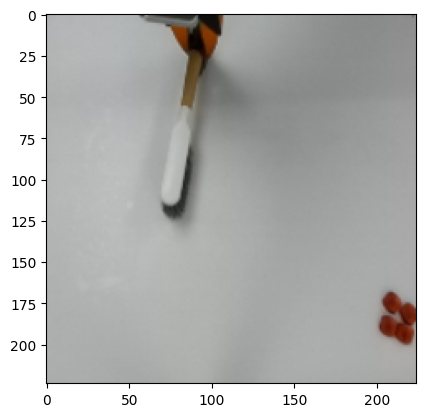

In [4]:

pixel_keys = ["rs", "zed_right"]

all_acs = []
transitions = 0

blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

hdf5_file = '/data/sunny/sweeper/proxy_anchor/optimal/traj_0053.hdf5'
with h5py.File(hdf5_file, "r+") as f:
    data_group = f["data"]
    cam_zed = data_group["camera_1"][:]
    # cam_rs = data_group["camera_0"][:]
    print(f"Processing {hdf5_file} with shape {cam_zed.shape}")
    
    idx = -1
    zed_img = cam_zed[idx]
    # rs_img = cam_rs[idx]
    img_PIL = Image.fromarray(np.uint8(zed_img)).convert('RGB')
    # img_tensor = DINO_crop(img_PIL)
    # dino_tensor = get_dino_features(dinov2, img_tensor.unsqueeze(0))
    

    plt.imshow(crop_transform(zed_img).permute(1, 2, 0).numpy())
    plt.show()
    # plt.imshow(rs_img)
    # plt.show()
    
